# 🧪 Lab: MLflow Tracking พื้นฐาน

**วัตถุประสงค์การเรียนรู้:**
- เข้าใจองค์ประกอบหลัก 5 ส่วนของ MLflow Tracking
- สามารถสร้าง Experiment และ Run ได้
- บันทึก Parameters, Metrics และ Artifacts ได้อย่างถูกต้อง
- บันทึกและโหลด Model ได้
- เปรียบเทียบผลการทดลองผ่าน MLflow UI

**องค์ประกอบหลักของ MLflow Tracking:**
| องค์ประกอบ | คำอธิบาย | ตัวอย่าง |
|------------|----------|----------|
| **Experiment** | กลุ่มของการทดลองที่เกี่ยวข้องกัน | `fraud-detection`, `customer-churn` |
| **Run** | การทดลองแต่ละครั้ง | แต่ละครั้งที่ train model |
| **Parameters** | ค่าที่ตั้งก่อนเริ่มทดลอง (Input) | `learning_rate=0.001`, `epochs=100` |
| **Metrics** | ค่าที่วัดได้จากการทดลอง (Output) | `accuracy=0.92`, `loss=0.15` |
| **Artifacts** | ไฟล์ที่สร้างจากการทดลอง | `model.pkl`, `confusion_matrix.png` |

---
## ⚙️ Pre-requisite: เตรียมความพร้อมก่อนเริ่ม Lab

### 📋 สิ่งที่ต้องมี

ก่อนเริ่ม Lab นี้ ต้องมี MLflow Server รันอยู่และเข้าถึงได้ที่ `http://127.0.0.1:5000`

### 🔍 ตรวจสอบ MLflow Server

เปิด Browser แล้วไปที่: [http://127.0.0.1:5000](http://127.0.0.1:5000)

![MLflow UI](./img/1.png)

---
## 📚 ส่วนที่ 1: การเชื่อมต่อ MLflow Server

### แนวคิด
ก่อนใช้งาน MLflow Tracking ต้องกำหนด **Tracking URI** เพื่อบอกว่าจะเก็บข้อมูลการทดลองไว้ที่ไหน

### ฟังก์ชันสำคัญ
| ฟังก์ชัน | คำอธิบาย |
|----------|----------|
| `mlflow.set_tracking_uri(uri)` | กำหนด URL ของ MLflow Server |
| `mlflow.get_tracking_uri()` | ตรวจสอบ URL ที่กำหนดไว้ |

### ทางเลือกอื่นสำหรับ Tracking URI
| ประเภท | ตัวอย่าง URI | คำอธิบาย |
|--------|--------------|----------|
| Local File | `file:///path/to/mlruns` | เก็บในโฟลเดอร์ local |
| Remote Server | `http://server:5000` | เก็บบน MLflow Server |
| Databricks | `databricks` | เก็บบน Databricks |
| SQLite | `sqlite:///mlflow.db` | เก็บใน SQLite database |

In [1]:
import mlflow
import os

# กำหนด MLflow Tracking URI
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"

# กำหนด Tracking URI ไปยัง MLflow Server
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# ตรวจสอบว่าเชื่อมต่อถูกต้อง
print(f"✅ MLflow Tracking URI: {mlflow.get_tracking_uri()}")

✅ MLflow Tracking URI: http://127.0.0.1:5000


---
## 📚 ส่วนที่ 2: การสร้าง Experiment

### แนวคิด
**Experiment** คือกลุ่มของ Runs ที่เกี่ยวข้องกัน เปรียบเสมือน "โปรเจกต์" หรือ "หัวข้อการทดลอง"

```
Experiment: fraud-detection-project
├── Run 1: baseline-model
├── Run 2: lstm-v1
├── Run 3: lstm-v2-tuned
└── Run 4: transformer-model
```

### หลักการตั้งชื่อ Experiment
| ✅ ชื่อที่ดี | ❌ ชื่อที่ควรหลีกเลี่ยง |
|-------------|------------------------|
| `fraud-detection-lstm` | `test` |
| `customer-churn-prediction` | `experiment1` |
| `image-classification-resnet` | `my_model` |

### ฟังก์ชันสำคัญ
| ฟังก์ชัน | คำอธิบาย |
|----------|----------|
| `mlflow.set_experiment(name)` | สร้างหรือเลือก Experiment |
| `mlflow.get_experiment_by_name(name)` | ดึงข้อมูล Experiment |

### คุณสมบัติของ Experiment Object
| คุณสมบัติ | คำอธิบาย |
|-----------|----------|
| `name` | ชื่อ Experiment |
| `experiment_id` | ID เฉพาะของ Experiment |
| `artifact_location` | ที่เก็บ Artifacts |
| `lifecycle_stage` | สถานะ (`active` หรือ `deleted`) |
| `tags` | Tags ที่กำหนด |

In [2]:
# สร้างหรือเลือก Experiment
experiment_name = "mlflow-tracking-lab"
mlflow.set_experiment(experiment_name)

# ดูข้อมูล Experiment
experiment = mlflow.get_experiment_by_name(experiment_name)
print(f"📁 Experiment Name: {experiment.name}")
print(f"🆔 Experiment ID: {experiment.experiment_id}")
print(f"📂 Artifact Location: {experiment.artifact_location}")
print(f"🔄 Lifecycle Stage: {experiment.lifecycle_stage}")

2026/01/05 13:05:17 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-tracking-lab' does not exist. Creating a new experiment.


📁 Experiment Name: mlflow-tracking-lab
🆔 Experiment ID: 1
📂 Artifact Location: mlflow-artifacts:/1
🔄 Lifecycle Stage: active


---
## 📚 ส่วนที่ 3: การสร้าง Run และบันทึก Parameters

### แนวคิด
**Run** คือการทดลองแต่ละครั้ง เป็นหน่วยพื้นฐานที่สุดของ MLflow Tracking
ทุกครั้งที่ train model ด้วย hyperparameters ชุดใหม่ ควรสร้าง Run ใหม่

**Parameters** คือค่าที่เราตั้งก่อนเริ่มการทดลอง (Input Configuration) 
เป็นค่าคงที่ตลอดการทดลอง ไม่เปลี่ยนแปลง

### ประเภทของ Parameters
| ประเภท | ตัวอย่าง |
|--------|----------|
| Model Hyperparameters | `learning_rate`, `batch_size`, `epochs` |
| Data Parameters | `train_split`, `image_size` |
| Architecture | `model_type`, `num_layers`, `hidden_units` |
| Training Config | `optimizer`, `loss_function` |

### ฟังก์ชันสำคัญ
| ฟังก์ชัน | คำอธิบาย |
|----------|----------|
| `mlflow.start_run(run_name)` | เริ่มต้น Run ใหม่ |
| `mlflow.log_param(key, value)` | บันทึก Parameter ทีละค่า |
| `mlflow.log_params(dict)` | บันทึกหลาย Parameters พร้อมกัน |
| `mlflow.active_run()` | ดึงข้อมูล Run ที่กำลังทำงานอยู่ |

### Context Manager (`with` statement)
การใช้ `with mlflow.start_run()` มีข้อดีคือ:
- Run จะถูกปิดอัตโนมัติเมื่อออกจาก block
- ป้องกันการลืมปิด Run
- จัดการ error ได้ดีกว่า

In [3]:
# กลับมาใช้ Experiment หลัก
mlflow.set_experiment("mlflow-tracking-lab")

# สร้าง Run และบันทึก Parameters
with mlflow.start_run(run_name="demo-parameters"):
    
    # วิธีที่ 1: บันทึกทีละค่า
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 100)
    
    # วิธีที่ 2: บันทึกหลายค่าพร้อมกัน (แนะนำ)
    mlflow.log_params({
        "optimizer": "adam",
        "dropout": 0.5,
        "hidden_units": 256,
        "activation": "relu",
        "model_type": "MLP"
    })
    
    # ดู Run ID
    run_id = mlflow.active_run().info.run_id
    print(f"✅ สร้าง Run สำเร็จ!")
    print(f"🆔 Run ID: {run_id}")
    print(f"📝 บันทึก Parameters: learning_rate, batch_size, epochs, optimizer, dropout, hidden_units, activation, model_type")

# เก็บ run_id สำหรับใช้ในส่วนถัดไป
demo_params_run_id = run_id

✅ สร้าง Run สำเร็จ!
🆔 Run ID: e64b7bdbf25e446996debd7fa3cc796c
📝 บันทึก Parameters: learning_rate, batch_size, epochs, optimizer, dropout, hidden_units, activation, model_type
🏃 View run demo-parameters at: http://127.0.0.1:5000/#/experiments/1/runs/e64b7bdbf25e446996debd7fa3cc796c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


# การอ่านข้อมูลจาก MLflow วิธีที่ 1 (อ่านจาก Run ID โดยตรง)

In [4]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# ดึงข้อมูล Run
run = client.get_run(demo_params_run_id)

# แสดงข้อมูลทั้งหมด
print("📊 Run Info:")
print(f"  - Run Name: {run.info.run_name}")
print(f"  - Status: {run.info.status}")
print(f"  - Start Time: {run.info.start_time}")

print("\n📝 Parameters:")
for key, value in run.data.params.items():
    print(f"  - {key}: {value}")

print("\n📈 Metrics:")
for key, value in run.data.metrics.items():
    print(f"  - {key}: {value}")

📊 Run Info:
  - Run Name: demo-parameters
  - Status: FINISHED
  - Start Time: 1767618317571

📝 Parameters:
  - learning_rate: 0.001
  - batch_size: 32
  - epochs: 100
  - optimizer: adam
  - dropout: 0.5
  - hidden_units: 256
  - activation: relu
  - model_type: MLP

📈 Metrics:


# การอ่านข้อมูลจาก MLflow วิธีที่ 2 (ค้นหา Runs จาก Experiment)

In [5]:
import mlflow

# วิธีที่ 1: ใช้ search_runs (ได้ DataFrame)
df = mlflow.search_runs(experiment_names=["mlflow-tracking-lab"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   run_id                   1 non-null      object             
 1   experiment_id            1 non-null      object             
 2   status                   1 non-null      object             
 3   artifact_uri             1 non-null      object             
 4   start_time               1 non-null      datetime64[ns, UTC]
 5   end_time                 1 non-null      datetime64[ns, UTC]
 6   params.optimizer         1 non-null      object             
 7   params.learning_rate     1 non-null      object             
 8   params.model_type        1 non-null      object             
 9   params.dropout           1 non-null      object             
 10  params.activation        1 non-null      object             
 11  params.hidden_units      1 non-null 

In [6]:
df.columns.tolist()

['run_id',
 'experiment_id',
 'status',
 'artifact_uri',
 'start_time',
 'end_time',
 'params.optimizer',
 'params.learning_rate',
 'params.model_type',
 'params.dropout',
 'params.activation',
 'params.hidden_units',
 'params.batch_size',
 'params.epochs',
 'tags.mlflow.source.type',
 'tags.mlflow.runName',
 'tags.mlflow.source.name',
 'tags.mlflow.user']

In [7]:
# ดูเฉพาะ columns ที่เป็น parameters
param_cols = [col for col in df.columns if col.startswith('params.')]

df[param_cols]

,params.optimizer,params.learning_rate,params.model_type,params.dropout,params.activation,params.hidden_units,params.batch_size,params.epochs
0,adam,0.001,MLP,0.5,relu,256,32,100


---
## 📚 ส่วนที่ 4: การบันทึก Metrics

### แนวคิด
**Metrics** คือค่าที่วัดได้จากการทดลอง (Output/Results) 
สามารถบันทึกได้หลายครั้งพร้อม step number เพื่อติดตามการเปลี่ยนแปลงตามเวลา

### ความแตกต่างระหว่าง Parameters และ Metrics
| คุณสมบัติ | Parameters | Metrics |
|-----------|------------|---------|
| เวลาบันทึก | ก่อนเริ่มทดลอง | ระหว่าง/หลังทดลอง |
| จำนวนค่า | ค่าเดียวต่อชื่อ | หลายค่าได้ (ต่าง step) |
| การเปลี่ยนแปลง | คงที่ | เปลี่ยนได้ตามเวลา |
| วัตถุประสงค์ | บอกว่าทำอะไร (Input) | บอกว่าได้ผลอย่างไร (Output) |

### ฟังก์ชันสำคัญ
| ฟังก์ชัน | คำอธิบาย |
|----------|----------|
| `mlflow.log_metric(key, value, step)` | บันทึก Metric ค่าเดียว |
| `mlflow.log_metrics(dict, step)` | บันทึกหลาย Metrics พร้อมกัน |

### การใช้ Step Parameter
Step ทำให้ MLflow สามารถสร้างกราฟแสดงการเปลี่ยนแปลงของ metric ตามเวลาได้

In [8]:
import random

with mlflow.start_run(run_name="demo-metrics"):
    
    # บันทึก Parameters ก่อน
    mlflow.log_params({
        "learning_rate": 0.01,
        "epochs": 10,
        "batch_size": 64
    })
    
    # จำลองการ Training และบันทึก Metrics ทุก epoch
    print("🚀 เริ่มการจำลอง Training...")
    
    for epoch in range(10):
        # จำลองค่า loss และ accuracy (ในการใช้งานจริงจะได้จากการ train)
        train_loss = 1.0 - (epoch * 0.08) + random.uniform(-0.05, 0.05)
        val_loss = 1.0 - (epoch * 0.07) + random.uniform(-0.05, 0.05)
        train_acc = 0.5 + (epoch * 0.04) + random.uniform(-0.02, 0.02)
        val_acc = 0.5 + (epoch * 0.035) + random.uniform(-0.02, 0.02)
        
        # บันทึก Metrics พร้อม step
        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        }, step=epoch)
        
        print(f"  Epoch {epoch+1}/10 - train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}")
    
    # บันทึก Final Metrics
    mlflow.log_metrics({
        "final_accuracy": val_acc,
        "final_loss": val_loss
    })
    
    # เก็บ run_id สำหรับใช้ในส่วนถัดไป
    demo_metrics_run_id = mlflow.active_run().info.run_id
    
    print(f"\n✅ Training เสร็จสิ้น!")
    print(f"📊 Final Accuracy: {val_acc:.4f}")
    print(f"🆔 Run ID: {demo_metrics_run_id}")

🚀 เริ่มการจำลอง Training...
  Epoch 1/10 - train_loss: 1.0242, val_loss: 1.0175, train_acc: 0.5117, val_acc: 0.5013
  Epoch 2/10 - train_loss: 0.9501, val_loss: 0.8990, train_acc: 0.5218, val_acc: 0.5198
  Epoch 3/10 - train_loss: 0.8722, val_loss: 0.9055, train_acc: 0.5956, val_acc: 0.5685
  Epoch 4/10 - train_loss: 0.7645, val_loss: 0.7515, train_acc: 0.6357, val_acc: 0.6117
  Epoch 5/10 - train_loss: 0.7033, val_loss: 0.7432, train_acc: 0.6700, val_acc: 0.6246
  Epoch 6/10 - train_loss: 0.5839, val_loss: 0.6658, train_acc: 0.6912, val_acc: 0.6615
  Epoch 7/10 - train_loss: 0.5354, val_loss: 0.5724, train_acc: 0.7454, val_acc: 0.6964
  Epoch 8/10 - train_loss: 0.4560, val_loss: 0.5537, train_acc: 0.7669, val_acc: 0.7307
  Epoch 9/10 - train_loss: 0.3912, val_loss: 0.4261, train_acc: 0.8354, val_acc: 0.7632
  Epoch 10/10 - train_loss: 0.3255, val_loss: 0.3973, train_acc: 0.8425, val_acc: 0.8016

✅ Training เสร็จสิ้น!
📊 Final Accuracy: 0.8016
🆔 Run ID: e432ec2db1d34dbd929f2335a4f6de06


 ## การอ่านข้อมูลจาก MLflow ใช้ Run ID โดยตรง

In [9]:
import mlflow

# ดึงข้อมูลจาก run_id ที่ได้
run = mlflow.get_run(demo_metrics_run_id)

# อ่าน Parameters
print("Parameters:", run.data.params)

# อ่าน Metrics (เฉพาะค่าสุดท้าย)
print("Metrics:", run.data.metrics)

# ข้อมูล run อื่นๆ
print("Run Name:", run.info.run_name)
print("Status:", run.info.status)
print("Start Time:", run.info.start_time)

Parameters: {'learning_rate': '0.01', 'epochs': '10', 'batch_size': '64'}
Metrics: {'train_loss': 0.3255171759330559, 'val_loss': 0.39727359202377427, 'train_accuracy': 0.8425186189716725, 'val_accuracy': 0.8016222619023674, 'final_accuracy': 0.8016222619023674, 'final_loss': 0.39727359202377427}
Run Name: demo-metrics
Status: FINISHED
Start Time: 1767618318198


#  การอ่านข้อมูลจาก MLflow ดึง Metric History (ทุก step)

In [10]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

history = client.get_metric_history(demo_metrics_run_id, "train_loss")
for m in history:
    print(f"Step {m.step}: {m.value:.4f}")

Step 0: 1.0242
Step 1: 0.9501
Step 2: 0.8722
Step 3: 0.7645
Step 4: 0.7033
Step 5: 0.5839
Step 6: 0.5354
Step 7: 0.4560
Step 8: 0.3912
Step 9: 0.3255


In [11]:
from mlflow.tracking import MlflowClient
import pandas as pd

client = MlflowClient()

# สร้าง DataFrame จาก metric history
metrics_data = {}
for metric_name in ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]:
    history = client.get_metric_history(demo_metrics_run_id, metric_name)
    metrics_data[metric_name] = [m.value for m in history]

df = pd.DataFrame(metrics_data)
df.index.name = "epoch"
print(df)

       train_loss  val_loss  train_accuracy  val_accuracy
epoch                                                    
0        1.024160  1.017489        0.511658      0.501264
1        0.950106  0.898988        0.521809      0.519781
2        0.872151  0.905465        0.595644      0.568480
3        0.764491  0.751492        0.635679      0.611671
4        0.703250  0.743161        0.669953      0.624570
5        0.583854  0.665808        0.691212      0.661451
6        0.535446  0.572408        0.745429      0.696435
7        0.456038  0.553679        0.766920      0.730725
8        0.391207  0.426131        0.835400      0.763217
9        0.325517  0.397274        0.842519      0.801622


---
## 📚 ส่วนที่ 5: การบันทึก Artifacts

### แนวคิด
**Artifacts** คือไฟล์ที่สร้างจากการทดลอง สามารถเป็นไฟล์ประเภทใดก็ได้
MLflow จะเก็บไว้ใน Artifact Store

### ประเภทของ Artifacts
| ประเภท | ตัวอย่างไฟล์ |
|--------|-------------|
| Models | `model.pkl`, `model.h5`, `model.pt` |
| Visualizations | `confusion_matrix.png`, `loss_curve.png` |
| Data | `predictions.csv`, `feature_importance.json` |
| Reports | `report.html`, `summary.pdf` |
| Configs | `config.yaml`, `hyperparams.json` |

### ฟังก์ชันสำคัญ
| ฟังก์ชัน | คำอธิบาย |
|----------|----------|
| `mlflow.log_artifact(local_path, artifact_path)` | บันทึกไฟล์เดี่ยว |
| `mlflow.log_artifacts(local_dir, artifact_path)` | บันทึกทั้งโฟลเดอร์ |
| `mlflow.log_figure(fig, artifact_file)` | บันทึก matplotlib figure |
| `mlflow.log_dict(dict, artifact_file)` | บันทึก dictionary เป็น JSON |
| `mlflow.log_text(text, artifact_file)` | บันทึก text |

In [12]:
import matplotlib.pyplot as plt
import mlflow
import os

# สร้างโฟลเดอร์สำหรับเก็บไฟล์ชั่วคราว
os.makedirs("outputs", exist_ok=True)

with mlflow.start_run(run_name="demo-artifacts"):
    
    # ----- Parameters -----
    params = {
        "model": "CNN",
        "epochs": 10,
        "learning_rate": 0.001,
        "batch_size": 32,
        "optimizer": "Adam"
    }
    mlflow.log_params(params)
    print("✅ บันทึก Parameters สำเร็จ")
    
    # ----- Metrics with Steps (บันทึกทีละ epoch) -----
    epochs = range(1, 11)
    train_loss = [1.0, 0.8, 0.65, 0.52, 0.42, 0.35, 0.30, 0.26, 0.23, 0.20]
    val_loss = [1.1, 0.9, 0.75, 0.62, 0.55, 0.50, 0.47, 0.45, 0.44, 0.43]
    train_acc = [0.5, 0.6, 0.68, 0.74, 0.79, 0.83, 0.86, 0.88, 0.90, 0.92]
    val_acc = [0.48, 0.55, 0.62, 0.68, 0.72, 0.75, 0.77, 0.78, 0.79, 0.80]
    
    # บันทึก metrics พร้อม step number
    for epoch in epochs:
        i = epoch - 1  # index สำหรับ list
        mlflow.log_metrics({
            "train_loss": train_loss[i],
            "val_loss": val_loss[i],
            "train_accuracy": train_acc[i],
            "val_accuracy": val_acc[i]
        }, step=epoch)
    
    print("✅ บันทึก Metrics (10 epochs) สำเร็จ")
    
    # ----- Artifact 1: บันทึก Figure จาก matplotlib -----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # กราฟ Loss
    axes[0].plot(epochs, train_loss, 'b-o', label='Train Loss', markersize=4)
    axes[0].plot(epochs, val_loss, 'r-o', label='Validation Loss', markersize=4)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # กราฟ Accuracy
    axes[1].plot(epochs, train_acc, 'b-o', label='Train Accuracy', markersize=4)
    axes[1].plot(epochs, val_acc, 'r-o', label='Validation Accuracy', markersize=4)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # บันทึก figure
    mlflow.log_figure(fig, artifact_file="plots/training_curves.png")
    plt.close(fig)
    print("✅ บันทึก training_curves.png สำเร็จ")
    
    # ----- Artifact 2: บันทึก Training History เป็น CSV -----
    with open("outputs/training_history.csv", "w") as f:
        f.write("epoch,train_loss,val_loss,train_accuracy,val_accuracy\n")
        for epoch in epochs:
            i = epoch - 1
            f.write(f"{epoch},{train_loss[i]},{val_loss[i]},{train_acc[i]},{val_acc[i]}\n")
    
    mlflow.log_artifact("outputs/training_history.csv", artifact_path="data")
    print("✅ บันทึก training_history.csv สำเร็จ")
    
    # ----- Artifact 3: บันทึก Dictionary เป็น JSON -----
    config = {
        "model_architecture": "CNN",
        "input_shape": [224, 224, 3],
        "num_classes": 10,
        "layers": ["Conv2D", "MaxPooling", "Conv2D", "MaxPooling", "Dense", "Softmax"]
    }
    mlflow.log_dict(config, artifact_file="config/model_config.json")
    print("✅ บันทึก model_config.json สำเร็จ")
    
    # ----- Artifact 4: บันทึก Text -----
    model_info = """Model: CNN Classifier v1.0
Created: 2024
Author: MLflow Lab
Description: Demo model for MLflow Tracking Lab
"""
    mlflow.log_text(model_info, artifact_file="models/model_info.txt")
    print("✅ บันทึก model_info.txt สำเร็จ")
    
    # ----- Artifact 5: บันทึก Predictions CSV -----
    with open("outputs/predictions.csv", "w") as f:
        f.write("id,true_label,predicted_label,confidence\n")
        f.write("1,cat,cat,0.95\n")
        f.write("2,dog,dog,0.88\n")
        f.write("3,bird,cat,0.45\n")
    
    mlflow.log_artifact("outputs/predictions.csv", artifact_path="data")
    print("✅ บันทึก predictions.csv สำเร็จ")
    
    # เก็บ run_id สำหรับใช้ในส่วนถัดไป
    demo_artifacts_run_id = mlflow.active_run().info.run_id
    
    print(f"\n📦 สรุป:")
    print(f"   - Parameters: {len(params)} รายการ")
    print(f"   - Metrics: 4 metrics × 10 steps")
    print(f"   - Artifacts: 5 ไฟล์")
    print(f"🆔 Run ID: {demo_artifacts_run_id}")
    print(f"🔗 ดูได้ที่ MLflow UI: http://127.0.0.1:5000")

✅ บันทึก Parameters สำเร็จ
✅ บันทึก Metrics (10 epochs) สำเร็จ
✅ บันทึก training_curves.png สำเร็จ
✅ บันทึก training_history.csv สำเร็จ
✅ บันทึก model_config.json สำเร็จ
✅ บันทึก model_info.txt สำเร็จ
✅ บันทึก predictions.csv สำเร็จ

📦 สรุป:
   - Parameters: 5 รายการ
   - Metrics: 4 metrics × 10 steps
   - Artifacts: 5 ไฟล์
🆔 Run ID: 9ad8d7331b364fd6aa2d76d732da5019
🔗 ดูได้ที่ MLflow UI: http://127.0.0.1:5000
🏃 View run demo-artifacts at: http://127.0.0.1:5000/#/experiments/1/runs/9ad8d7331b364fd6aa2d76d732da5019
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


# วิธีอ่าน Artifacts, Metrics และ Parameters จาก MLflow

In [13]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import json

# ดึงข้อมูล run
client = mlflow.tracking.MlflowClient()
run = client.get_run(demo_artifacts_run_id)

# =============================================
# 1. อ่าน Parameters
# =============================================
print("=" * 50)
print("📋 PARAMETERS")
print("=" * 50)
params = run.data.params
for key, value in params.items():
    print(f"  {key}: {value}")

# =============================================
# 2. อ่าน Metrics (ค่าสุดท้าย)
# =============================================
print("\n" + "=" * 50)
print("📊 METRICS (Final Values)")
print("=" * 50)
metrics = run.data.metrics
for key, value in metrics.items():
    print(f"  {key}: {value}")

# =============================================
# 3. อ่าน Metrics History (ทุก step)
# =============================================
print("\n" + "=" * 50)
print("📈 METRICS HISTORY")
print("=" * 50)

# ดึง history ของแต่ละ metric
metric_names = ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]
history_data = {}

for metric_name in metric_names:
    history = client.get_metric_history(demo_artifacts_run_id, metric_name)
    history_data[metric_name] = {h.step: h.value for h in history}
    print(f"\n{metric_name}:")
    for h in history:
        print(f"  Step {h.step}: {h.value}")

📋 PARAMETERS
  model: CNN
  epochs: 10
  learning_rate: 0.001
  batch_size: 32
  optimizer: Adam

📊 METRICS (Final Values)
  train_loss: 0.2
  val_loss: 0.43
  train_accuracy: 0.92
  val_accuracy: 0.8

📈 METRICS HISTORY

train_loss:
  Step 1: 1.0
  Step 2: 0.8
  Step 3: 0.65
  Step 4: 0.52
  Step 5: 0.42
  Step 6: 0.35
  Step 7: 0.3
  Step 8: 0.26
  Step 9: 0.23
  Step 10: 0.2

val_loss:
  Step 1: 1.1
  Step 2: 0.9
  Step 3: 0.75
  Step 4: 0.62
  Step 5: 0.55
  Step 6: 0.5
  Step 7: 0.47
  Step 8: 0.45
  Step 9: 0.44
  Step 10: 0.43

train_accuracy:
  Step 1: 0.5
  Step 2: 0.6
  Step 3: 0.68
  Step 4: 0.74
  Step 5: 0.79
  Step 6: 0.83
  Step 7: 0.86
  Step 8: 0.88
  Step 9: 0.9
  Step 10: 0.92

val_accuracy:
  Step 1: 0.48
  Step 2: 0.55
  Step 3: 0.62
  Step 4: 0.68
  Step 5: 0.72
  Step 6: 0.75
  Step 7: 0.77
  Step 8: 0.78
  Step 9: 0.79
  Step 10: 0.8



📦 ARTIFACTS
Downloaded to: /tmp/tmp4u44_7m5/

🖼️ แสดงรูปภาพ training_curves.png:


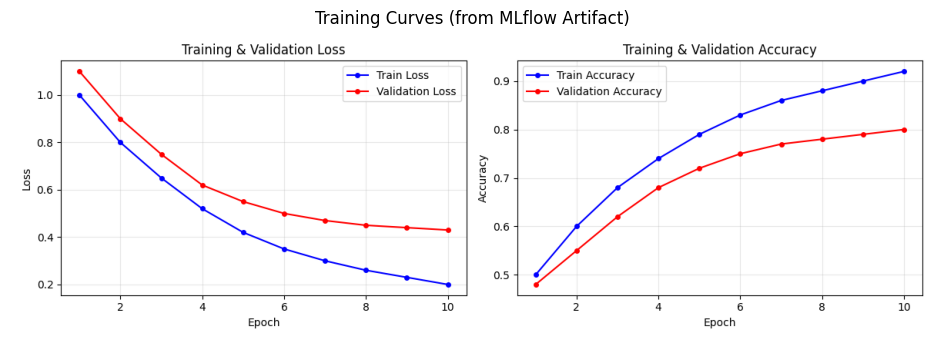


📄 แสดง training_history.csv:
 epoch  train_loss  val_loss  train_accuracy  val_accuracy
     1        1.00      1.10            0.50          0.48
     2        0.80      0.90            0.60          0.55
     3        0.65      0.75            0.68          0.62
     4        0.52      0.62            0.74          0.68
     5        0.42      0.55            0.79          0.72
     6        0.35      0.50            0.83          0.75
     7        0.30      0.47            0.86          0.77
     8        0.26      0.45            0.88          0.78
     9        0.23      0.44            0.90          0.79
    10        0.20      0.43            0.92          0.80

📄 แสดง predictions.csv:
 id true_label predicted_label  confidence
  1        cat             cat        0.95
  2        dog             dog        0.88
  3       bird             cat        0.45

📄 แสดง model_config.json:
{
  "model_architecture": "CNN",
  "input_shape": [
    224,
    224,
    3
  ],
  "num_classes":

In [14]:
# =============================================
# 4. อ่าน Artifacts
# =============================================
print("\n" + "=" * 50)
print("📦 ARTIFACTS")
print("=" * 50)

# ดาวน์โหลด artifacts ทั้งหมดไปยังโฟลเดอร์ local
artifacts_path = mlflow.artifacts.download_artifacts(run_id=demo_artifacts_run_id)
print(f"Downloaded to: {artifacts_path}")

# --- 4.1 แสดงรูปภาพ (PNG) ---
print("\n🖼️ แสดงรูปภาพ training_curves.png:")
img_path = f"{artifacts_path}/plots/training_curves.png"
if os.path.exists(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(12, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Training Curves (from MLflow Artifact)")
    plt.show()
else:
    print(f"  ไม่พบไฟล์: {img_path}")

# --- 4.2 แสดง CSV ด้วย Pandas ---
print("\n📄 แสดง training_history.csv:")
csv_path = f"{artifacts_path}/data/training_history.csv"
if os.path.exists(csv_path):
    df_history = pd.read_csv(csv_path)
    print(df_history.to_string(index=False))
else:
    print(f"  ไม่พบไฟล์: {csv_path}")

print("\n📄 แสดง predictions.csv:")
csv_path2 = f"{artifacts_path}/data/predictions.csv"
if os.path.exists(csv_path2):
    df_pred = pd.read_csv(csv_path2)
    print(df_pred.to_string(index=False))
else:
    print(f"  ไม่พบไฟล์: {csv_path2}")

# --- 4.3 แสดง JSON ---
print("\n📄 แสดง model_config.json:")
json_path = f"{artifacts_path}/config/model_config.json"
if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        config = json.load(f)
    print(json.dumps(config, indent=2))
else:
    print(f"  ไม่พบไฟล์: {json_path}")

# --- 4.4 แสดง Text ---
print("\n📄 แสดง model_info.txt:")
txt_path = f"{artifacts_path}/models/model_info.txt"
if os.path.exists(txt_path):
    with open(txt_path, 'r') as f:
        print(f.read())
else:
    print(f"  ไม่พบไฟล์: {txt_path}")

---
## 📚 ส่วนที่ 6: การบันทึก Model (Model Logging)

### แนวคิด
**Model Logging** เป็นฟีเจอร์สำคัญของ MLflow ที่ช่วยให้เราสามารถบันทึก Model 
พร้อมกับข้อมูลที่จำเป็นสำหรับการนำไปใช้งาน (Deployment) ได้อย่างสมบูรณ์

### ประโยชน์ของการบันทึก Model ผ่าน MLflow
- บันทึก Model พร้อม dependencies และ environment
- สามารถโหลด Model กลับมาใช้งานได้ง่าย
- รองรับการ Deploy ไปยัง Production
- เก็บ Model signature (input/output schema)

### MLflow Model Flavors
| Flavor | Library | ฟังก์ชัน |
|--------|---------|----------|
| `mlflow.sklearn` | Scikit-learn | `log_model()`, `load_model()` |
| `mlflow.pytorch` | PyTorch | `log_model()`, `load_model()` |
| `mlflow.tensorflow` | TensorFlow/Keras | `log_model()`, `load_model()` |
| `mlflow.xgboost` | XGBoost | `log_model()`, `load_model()` |
| `mlflow.pyfunc` | Generic Python | `log_model()`, `load_model()` |

### 6.1 การบันทึก Scikit-learn Model

**ฟังก์ชันสำคัญ:**
- `mlflow.sklearn.log_model()` บันทึก sklearn model
- `artifact_path` กำหนดชื่อโฟลเดอร์ที่จะเก็บ model
- `signature` บันทึก input/output schema ของ model
- `input_example` ตัวอย่าง input สำหรับอ้างอิง

In [15]:
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mlflow.models import infer_signature

# โหลดข้อมูล Iris dataset
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=42
)

with mlflow.start_run(run_name="sklearn-model-demo"):
    
    # กำหนด hyperparameters
    n_estimators = 100
    max_depth = 5
    random_state = 42
    
    # บันทึก Parameters
    mlflow.log_params({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "random_state": random_state,
        "model_type": "RandomForestClassifier"
    })
    
    # สร้างและ Train Model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    
    # ทำนายและคำนวณ Metrics
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # บันทึก Metrics
    mlflow.log_metric("accuracy", accuracy)
    print(f"📊 Accuracy: {accuracy:.4f}")
    
    # สร้าง Signature
    signature = infer_signature(X_train, model.predict(X_train))
    
    # บันทึก Model
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        signature=signature,
        input_example=X_train[:3]
    )
    
    print(f"✅ บันทึก Model สำเร็จ!")
    print(f"📦 Model ถูกเก็บไว้ใน artifacts/model/")
    
    sklearn_run_id = mlflow.active_run().info.run_id
    print(f"🆔 Run ID: {sklearn_run_id}")

2026/01/05 13:05:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 Accuracy: 1.0000
✅ บันทึก Model สำเร็จ!
📦 Model ถูกเก็บไว้ใน artifacts/model/
🆔 Run ID: 67f5697764904cff885a308d89cdafd0
🏃 View run sklearn-model-demo at: http://127.0.0.1:5000/#/experiments/1/runs/67f5697764904cff885a308d89cdafd0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 6.2 การโหลด Model กลับมาใช้งาน

**วิธีการโหลด Model จาก ARTIFACTS_BASE โดยตรง (เร็วที่สุด! ⚡)**

เมื่อใช้ `--serve-artifacts` กับ MLflow Server, **Models จะถูกเก็บในโฟลเดอร์ `models/` แยกต่างหาก**:

```
mlartifacts/
└── <experiment_id>/
    ├── <run_id>/
    │   └── artifacts/           # Artifacts ทั่วไป (plots, data, config)
    └── models/                  # ⚠️ Models ถูกเก็บที่นี่!
        └── m-<model_id>/        
            └── artifacts/
                ├── MLmodel
                ├── model.pkl
                └── ...
```

In [16]:
# =============================================================
# โหลด Model จาก ARTIFACTS_BASE โดยตรง (เร็วที่สุด! ⚡)
# =============================================================

# กำหนด ARTIFACTS_BASE path ตาม MLflow Server configuration
ARTIFACTS_BASE = "/home/student/workspace/mlflowserver-lab/mlartifacts"

# ดึงข้อมูล Experiment ID
experiment = mlflow.get_experiment_by_name("mlflow-tracking-lab")
experiment_id = experiment.experiment_id

print(f"📁 ARTIFACTS_BASE: {ARTIFACTS_BASE}")
print(f"🆔 Experiment ID: {experiment_id}")
print(f"🆔 Run ID: {sklearn_run_id}")

📁 ARTIFACTS_BASE: /home/student/workspace/mlflowserver-lab/mlartifacts
🆔 Experiment ID: 1
🆔 Run ID: 67f5697764904cff885a308d89cdafd0


In [17]:
# =============================================================
# Helper Function: ค้นหา Model ตาม flavor (sklearn, pytorch, etc.)
# =============================================================
import yaml

def find_model_path_by_flavor(artifacts_base: str, experiment_id: str, flavor: str = "sklearn") -> str:
    """
    ค้นหา model path จาก models/ folder ตาม flavor ที่ต้องการ
    (MLflow เก็บ models แยกใน models/ folder เมื่อใช้ --serve-artifacts)
    
    Args:
        artifacts_base: Base path ของ artifacts
        experiment_id: Experiment ID
        flavor: MLflow flavor ที่ต้องการ ("sklearn", "pytorch", "tensorflow", etc.)
    
    Returns:
        Full path ไปยัง model หรือ None ถ้าไม่พบ
    """
    models_folder = f"{artifacts_base}/{experiment_id}/models"
    
    if not os.path.exists(models_folder):
        return None
    
    # ค้นหา model folder ที่มี flavor ตรงกับที่ต้องการ
    for model_dir in os.listdir(models_folder):
        model_path = f"{models_folder}/{model_dir}/artifacts"
        mlmodel_file = f"{model_path}/MLmodel"
        
        if os.path.exists(mlmodel_file):
            # อ่าน MLmodel file เพื่อตรวจสอบ flavor
            with open(mlmodel_file, 'r') as f:
                mlmodel = yaml.safe_load(f)
            
            # ตรวจสอบว่ามี flavor ที่ต้องการหรือไม่
            if 'flavors' in mlmodel and flavor in mlmodel['flavors']:
                return model_path
    
    return None

# ค้นหาและโหลด sklearn model
model_path = find_model_path_by_flavor(ARTIFACTS_BASE, experiment_id, flavor="sklearn")

if model_path:
    print(f"📦 Model Path: {model_path}")
    
    # โหลด model
    loaded_model = mlflow.sklearn.load_model(model_path)
    print(f"✅ โหลด Model สำเร็จ: {type(loaded_model)}")
    
    # ทดสอบทำนาย
    sample_data = X_test[:5]
    predictions = loaded_model.predict(sample_data)
    print(f"\n🔮 ทดสอบทำนาย 5 ตัวอย่างแรก:")
    print(f"   Predictions: {predictions}")
    print(f"   Actual:      {y_test[:5]}")
else:
    print("⚠️ ไม่พบ model")

📦 Model Path: /home/student/workspace/mlflowserver-lab/mlartifacts/1/models/m-4ad835693e724654ba9434c3b2f26192/artifacts
✅ โหลด Model สำเร็จ: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

🔮 ทดสอบทำนาย 5 ตัวอย่างแรก:
   Predictions: [1 0 2 1 1]
   Actual:      [1 0 2 1 1]


### 6.3 การบันทึก PyTorch Model

**ฟังก์ชันสำคัญ:**
- `mlflow.pytorch.log_model()` บันทึก PyTorch model
- รองรับทั้ง `nn.Module` และ `torch.jit.ScriptModule`
- สามารถระบุ `conda_env` หรือ `pip_requirements` ได้

In [27]:
import torch
import torch.nn as nn

# สร้าง Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

with mlflow.start_run(run_name="pytorch-model-demo"):
    
    # กำหนด hyperparameters
    input_size = 4
    hidden_size = 16
    num_classes = 3
    learning_rate = 0.01
    epochs = 100
    
    # บันทึก Parameters
    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_classes": num_classes,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "model_type": "SimpleNN"
    })
    
    # สร้าง Model
    pytorch_model = SimpleNN(input_size, hidden_size, num_classes)
    
    # เตรียมข้อมูล - แปลงเป็น float32 เพื่อให้ตรงกับ PyTorch default
    X_train_float32 = X_train.astype('float32')
    X_test_float32 = X_test.astype('float32')
    
    X_tensor = torch.FloatTensor(X_train_float32)
    y_tensor = torch.LongTensor(y_train)
    
    # Training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=learning_rate)
    
    print("🚀 เริ่ม Training PyTorch Model...")
    for epoch in range(epochs):
        outputs = pytorch_model(X_tensor)
        loss = criterion(outputs, y_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            mlflow.log_metric("train_loss", loss.item(), step=epoch)
            print(f"   Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    # คำนวณ Accuracy
    pytorch_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_float32)
        outputs = pytorch_model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted.numpy() == y_test).sum() / len(y_test)
    
    mlflow.log_metric("accuracy", accuracy)
    print(f"\n📊 Test Accuracy: {accuracy:.4f}")
    
    # สร้าง Signature - ใช้ float32 data
    signature = infer_signature(
        X_train_float32, 
        pytorch_model(torch.FloatTensor(X_train_float32)).detach().numpy()
    )
    
    # บันทึก PyTorch Model - ใช้ name แทน artifact_path
    mlflow.pytorch.log_model(
        pytorch_model=pytorch_model,
        name="pytorch_model",  # เปลี่ยนจาก artifact_path เป็น name
        signature=signature,
        input_example=X_train_float32[:3]
    )
    
    print(f"✅ บันทึก PyTorch Model สำเร็จ!")
    pytorch_run_id = mlflow.active_run().info.run_id
    print(f"🆔 Run ID: {pytorch_run_id}")

🚀 เริ่ม Training PyTorch Model...
   Epoch [20/100], Loss: 1.0458
   Epoch [40/100], Loss: 0.8438
   Epoch [60/100], Loss: 0.6790
   Epoch [80/100], Loss: 0.5871
   Epoch [100/100], Loss: 0.4810

📊 Test Accuracy: 1.0000


2026/01/05 13:08:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.9.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/01/05 13:08:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==2.9.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


✅ บันทึก PyTorch Model สำเร็จ!
🆔 Run ID: 8e0be9c21bf945699fa9dd284b59681e
🏃 View run pytorch-model-demo at: http://127.0.0.1:5000/#/experiments/1/runs/8e0be9c21bf945699fa9dd284b59681e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 6.4 โหลด PyTorch Model จาก ARTIFACTS_BASE

In [29]:
# โหลด PyTorch Model (ใช้ find_model_path_by_flavor ที่สร้างไว้ใน 6.2)
print("="*60)
print("🔥 โหลด PyTorch Model จาก ARTIFACTS_BASE")
print("="*60)

pytorch_model_path = find_model_path_by_flavor(ARTIFACTS_BASE, experiment_id, flavor="pytorch")

if pytorch_model_path:
    print(f"📦 PyTorch Model Path: {pytorch_model_path}")
    
    # โหลด model
    loaded_pytorch_model = mlflow.pytorch.load_model(pytorch_model_path)
    print(f"✅ โหลด PyTorch Model สำเร็จ: {type(loaded_pytorch_model)}")
    
    # ทดสอบทำนาย
    loaded_pytorch_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_float32[:5])
        outputs = loaded_pytorch_model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        print(f"\n🔮 ทดสอบทำนาย 5 ตัวอย่างแรก:")
        print(f"   Predictions: {predicted.numpy()}")
        print(f"   Actual:      {y_test[:5]}")
else:
    print("⚠️ ไม่พบ PyTorch model")

🔥 โหลด PyTorch Model จาก ARTIFACTS_BASE
📦 PyTorch Model Path: /home/student/workspace/mlflowserver-lab/mlartifacts/1/models/m-accbb01905b74cfe815851e32002534f/artifacts
✅ โหลด PyTorch Model สำเร็จ: <class '__main__.SimpleNN'>

🔮 ทดสอบทำนาย 5 ตัวอย่างแรก:
   Predictions: [1 0 2 1 1]
   Actual:      [1 0 2 1 1]


### 6.5 การบันทึก Model ด้วย Autolog

**Autolog** เป็นฟีเจอร์ที่ช่วยบันทึก Parameters, Metrics และ Model อัตโนมัติ
โดยไม่ต้องเขียนโค้ดบันทึกเอง

**รองรับหลาย Framework:**
- `mlflow.sklearn.autolog()`
- `mlflow.pytorch.autolog()`
- `mlflow.tensorflow.autolog()`
- `mlflow.xgboost.autolog()`
- `mlflow.lightgbm.autolog()`

In [20]:
from sklearn.linear_model import LogisticRegression

# เปิด Autolog สำหรับ sklearn
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="autolog-demo"):
    # แค่ train model ตามปกติ MLflow จะบันทึกทุกอย่างอัตโนมัติ
    auto_model = LogisticRegression(max_iter=200, C=1.0, solver='lbfgs')
    auto_model.fit(X_train, y_train)
    
    # คำนวณ accuracy (Autolog จะบันทึก metrics พื้นฐานให้)
    accuracy = auto_model.score(X_test, y_test)
    print(f"📊 Accuracy: {accuracy:.4f}")
    print(f"✅ Autolog บันทึก Parameters, Metrics และ Model อัตโนมัติ!")

# ปิด Autolog หลังใช้งาน
mlflow.sklearn.autolog(disable=True)

📊 Accuracy: 1.0000
✅ Autolog บันทึก Parameters, Metrics และ Model อัตโนมัติ!
🏃 View run autolog-demo at: http://127.0.0.1:5000/#/experiments/1/runs/716c81f4f7de4e09bd0335a1095c6647
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 6.6 สรุปวิธีการโหลด Model

| วิธี | Code | Use Case |
|------|------|----------|
| **โหลดจาก ARTIFACTS_BASE** | `find_model_path_by_flavor(base, exp_id, "sklearn")` | Production บน Server เดียวกัน (เร็วที่สุด!) |

**หมายเหตุ:** 
- เมื่อใช้ `--serve-artifacts` กับ MLflow Server, models จะถูกเก็บในโฟลเดอร์ `models/` แยกต่างหาก
- ใช้ parameter `flavor` เพื่อระบุประเภท model ที่ต้องการ ("sklearn", "pytorch", "tensorflow", etc.)

---
## 📚 ส่วนที่ 7: Nested Runs (การรันซ้อนกัน)

### แนวคิด
**Nested Runs** ใช้สำหรับจัดกลุ่มการทดลองที่เกี่ยวข้องกัน โดยเฉพาะในกรณี:
- Hyperparameter Tuning (ทดลองหลายค่าพารามิเตอร์)
- Cross-Validation (ทดลองหลาย folds)
- Ensemble Models (รวมหลาย models)

### โครงสร้าง Nested Runs
```
Parent Run: hyperparameter-tuning
├── Child Run 1: lr=0.001 → accuracy=0.85
├── Child Run 2: lr=0.01  → accuracy=0.92 ⭐
└── Child Run 3: lr=0.1   → accuracy=0.70
```

### ข้อดีของ Nested Runs
| ข้อดี | คำอธิบาย |
|-------|----------|
| จัดระเบียบ | จัดกลุ่มการทดลองที่เกี่ยวข้องไว้ด้วยกัน |
| เปรียบเทียบง่าย | เห็นผลการทดลองทั้งหมดในที่เดียว |
| สรุปผล | Parent Run เก็บผลลัพธ์ที่ดีที่สุด |
| UI ชัดเจน | แสดงเป็น tree structure ใน MLflow UI |

In [21]:
import random

# จำลอง Hyperparameter Tuning ด้วย Nested Runs
learning_rates = [0.001, 0.01, 0.1]

with mlflow.start_run(run_name="hyperparameter-tuning"):
    print("🔄 เริ่ม Hyperparameter Tuning...")
    
    # บันทึก Parameters ของ Parent Run
    mlflow.log_param("experiment_type", "learning_rate_search")
    mlflow.log_param("search_space", str(learning_rates))
    
    best_accuracy = 0
    best_lr = None
    
    for lr in learning_rates:
        # สร้าง Child Run สำหรับแต่ละ learning rate
        with mlflow.start_run(run_name=f"lr-{lr}", nested=True):
            mlflow.log_param("learning_rate", lr)
            
            # จำลองการ training (ในการใช้งานจริงจะ train model จริง)
            # learning rate ที่เหมาะสมคือ 0.01
            if lr == 0.01:
                accuracy = 0.92 + random.uniform(-0.02, 0.02)
            elif lr == 0.001:
                accuracy = 0.85 + random.uniform(-0.02, 0.02)
            else:  # lr = 0.1
                accuracy = 0.70 + random.uniform(-0.05, 0.05)
            
            mlflow.log_metric("accuracy", accuracy)
            print(f"  ✅ lr={lr} → accuracy={accuracy:.4f}")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_lr = lr
    
    # บันทึกผลลัพธ์ที่ดีที่สุดใน Parent Run
    mlflow.log_metric("best_accuracy", best_accuracy)
    mlflow.log_param("best_learning_rate", best_lr)
    
    print(f"\n🏆 Best Result: lr={best_lr}, accuracy={best_accuracy:.4f}")

🔄 เริ่ม Hyperparameter Tuning...
  ✅ lr=0.001 → accuracy=0.8367
🏃 View run lr-0.001 at: http://127.0.0.1:5000/#/experiments/1/runs/6753c4bb2952419993a1077c58706066
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
  ✅ lr=0.01 → accuracy=0.9261
🏃 View run lr-0.01 at: http://127.0.0.1:5000/#/experiments/1/runs/f6ca72377ec144cd89851910b18fb935
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1
  ✅ lr=0.1 → accuracy=0.6729
🏃 View run lr-0.1 at: http://127.0.0.1:5000/#/experiments/1/runs/19a9b55ee0e44d599adfafa862e7bf8d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1

🏆 Best Result: lr=0.01, accuracy=0.9261
🏃 View run hyperparameter-tuning at: http://127.0.0.1:5000/#/experiments/1/runs/e6ad87026b8d4b1897049b22429c5d89
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


---
## 📚 ส่วนที่ 8: การดูข้อมูลจาก MLflow UI

หลังจากบันทึกข้อมูลการทดลองแล้ว เราสามารถดูและวิเคราะห์ผลลัพธ์ผ่าน MLflow UI 
ซึ่งเป็น Web Interface ที่ใช้งานง่าย

### 8.1 การเข้าถึง MLflow UI

เปิด Browser แล้วไปที่: [http://127.0.0.1:5000](http://127.0.0.1:5000)

![MLflow UI Homepage](./img/mlflow-ui-home.png)

### 8.2 ส่วนประกอบหลักของ MLflow UI

#### 📁 Experiments Sidebar (แถบด้านซ้าย)
แสดงรายการ Experiments ทั้งหมด สามารถคลิกเลือกเพื่อดู Runs ภายใน

#### 📋 Runs Table (ตารางกลาง)
แสดงรายการ Runs ทั้งหมดใน Experiment ที่เลือก พร้อมข้อมูล:
- **Run Name**: ชื่อ Run
- **Created**: วันเวลาที่สร้าง
- **Duration**: ระยะเวลาที่ใช้
- **Parameters**: ค่า Parameters ที่บันทึก
- **Metrics**: ค่า Metrics ที่บันทึก

### 8.3 การดูรายละเอียด Run

คลิกที่ Run Name เพื่อดูรายละเอียด จะเห็นหน้าที่แบ่งเป็น Tabs:

| Tab | คำอธิบาย |
|-----|----------|
| **Overview** | แสดงข้อมูลทั่วไปของ Run |
| **Parameters** | แสดง Parameters ทั้งหมดที่บันทึก |
| **Metrics** | แสดง Metrics พร้อมกราฟแสดงการเปลี่ยนแปลงตาม step |
| **Artifacts** | แสดงไฟล์ที่บันทึกไว้ สามารถ Preview หรือ Download ได้ |

### 8.4 การเปรียบเทียบหลาย Runs

#### วิธีการเปรียบเทียบ:
1. **เลือก Runs**: คลิก checkbox หน้า Runs ที่ต้องการเปรียบเทียบ
2. **คลิก Compare**: กดปุ่ม "Compare" ที่ด้านบน

#### หน้า Compare View:
แสดงการเปรียบเทียบแบบ side-by-side:
- **Parameters Comparison**: เปรียบเทียบค่า Parameters
- **Metrics Comparison**: เปรียบเทียบค่า Metrics พร้อมกราฟ

### 8.5 การค้นหาและ Filter Runs

#### ตัวอย่าง Filter Syntax:
| Filter | ความหมาย |
|--------|----------|
| `metrics.accuracy > 0.9` | Runs ที่มี accuracy มากกว่า 0.9 |
| `params.learning_rate = "0.01"` | Runs ที่ใช้ learning_rate = 0.01 |
| `params.model_type = "MLP"` | Runs ที่ใช้ model_type = MLP |
| `status = "FINISHED"` | Runs ที่ทำงานเสร็จแล้ว |

In [22]:
# ค้นหา Runs ใน Experiment
runs = mlflow.search_runs(
    experiment_names=["mlflow-tracking-lab"],
    order_by=["start_time DESC"],
    max_results=10
)

print("📋 Recent Runs:")
print("=" * 80)
for _, row in runs.iterrows():
    run_name = row.get("tags.mlflow.runName", "N/A")
    status = row["status"]
    start_time = row["start_time"]
    
    # ดึง metrics (ถ้ามี)
    accuracy = row.get("metrics.accuracy", "N/A")
    
    print(f"  Run: {run_name:<25} | Status: {status:<10} | Accuracy: {accuracy}")

print(f"\n🔗 ดูรายละเอียดเพิ่มเติมได้ที่: http://127.0.0.1:5000")

📋 Recent Runs:
  Run: lr-0.1                    | Status: FINISHED   | Accuracy: 0.6728543404517631
  Run: lr-0.01                   | Status: FINISHED   | Accuracy: 0.9261277258889253
  Run: lr-0.001                  | Status: FINISHED   | Accuracy: 0.8367141544132465
  Run: hyperparameter-tuning     | Status: FINISHED   | Accuracy: nan
  Run: autolog-demo              | Status: FINISHED   | Accuracy: nan
  Run: pytorch-model-demo        | Status: FINISHED   | Accuracy: 1.0
  Run: sklearn-model-demo        | Status: FINISHED   | Accuracy: 1.0
  Run: demo-artifacts            | Status: FINISHED   | Accuracy: nan
  Run: demo-metrics              | Status: FINISHED   | Accuracy: nan
  Run: demo-parameters           | Status: FINISHED   | Accuracy: nan

🔗 ดูรายละเอียดเพิ่มเติมได้ที่: http://127.0.0.1:5000


### 8.6 การดู Nested Runs

Nested Runs จะแสดงเป็นโครงสร้าง tree ใน UI:

```
📁 hyperparameter-tuning (Parent Run)
├── 📄 lr-0.001 (Child Run) - accuracy: 0.85
├── 📄 lr-0.01 (Child Run)  - accuracy: 0.92 ⭐
└── 📄 lr-0.1 (Child Run)   - accuracy: 0.70
```

คลิกที่ Parent Run จะเห็น Child Runs ทั้งหมด

### 8.7 การ Download Artifacts

#### วิธี Download ผ่าน UI:
1. เข้าไปที่หน้า Run Detail
2. คลิก Tab "Artifacts"
3. เลือกไฟล์ที่ต้องการ
4. คลิกปุ่ม Download

In [23]:
# Download artifacts ผ่าน Python
# หมายเหตุ: ต้องใส่ run_id จริงจากการทดลองก่อนหน้า

# ตัวอย่างการ download (uncomment เพื่อใช้งาน)
# run_id = "your-run-id-here"
# local_path = mlflow.artifacts.download_artifacts(
#     run_id=run_id,
#     artifact_path="",  # "" = download ทั้งหมด
#     dst_path="./downloaded_artifacts"
# )
# print(f"Downloaded to: {local_path}")

print("💡 Tip: ใช้ mlflow.artifacts.download_artifacts() เพื่อ download artifacts ผ่าน Python")

💡 Tip: ใช้ mlflow.artifacts.download_artifacts() เพื่อ download artifacts ผ่าน Python


### 8.8 การจัดการ Tags

Tags ช่วยจัดกลุ่มและค้นหา Runs ได้ง่ายขึ้น

In [24]:
with mlflow.start_run(run_name="tagged-run"):
    # บันทึก Tags
    mlflow.set_tag("team", "data-science")
    mlflow.set_tag("version", "v1.0")
    mlflow.set_tag("environment", "development")
    
    # บันทึกหลาย Tags พร้อมกัน
    mlflow.set_tags({
        "dataset": "iris",
        "framework": "sklearn"
    })
    
    # บันทึก parameter และ metric ตัวอย่าง
    mlflow.log_param("model", "demo")
    mlflow.log_metric("accuracy", 0.95)
    
    print("✅ บันทึก Tags สำเร็จ!")
    print("📌 Tags: team=data-science, version=v1.0, environment=development, dataset=iris, framework=sklearn")

✅ บันทึก Tags สำเร็จ!
📌 Tags: team=data-science, version=v1.0, environment=development, dataset=iris, framework=sklearn
🏃 View run tagged-run at: http://127.0.0.1:5000/#/experiments/1/runs/4d5d3892e8ad456bb1601b3e453da5a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### 8.9 ตัวอย่างโค้ดสำหรับวิเคราะห์ผลการทดลอง

In [25]:
import pandas as pd

# ค้นหา Runs ทั้งหมดใน Experiment
runs = mlflow.search_runs(
    experiment_names=["mlflow-tracking-lab"],
    order_by=["metrics.accuracy DESC"],
    max_results=20
)

# แสดงสรุปผลการทดลอง
print("🏆 Top 5 Runs by Accuracy:")
print("=" * 80)

top_runs = runs.head(5)
for idx, row in top_runs.iterrows():
    run_name = row.get("tags.mlflow.runName", "N/A")
    accuracy = row.get("metrics.accuracy", 0)
    lr = row.get("params.learning_rate", "N/A")
    
    if pd.notna(accuracy):
        print(f"  {run_name:<30} | Accuracy: {accuracy:.4f} | LR: {lr}")
    else:
        print(f"  {run_name:<30} | Accuracy: N/A | LR: {lr}")

# วิเคราะห์ความสัมพันธ์ระหว่าง Parameters และ Metrics
print("\n📊 Analysis:")
if "params.learning_rate" in runs.columns and "metrics.accuracy" in runs.columns:
    # กรองเฉพาะ rows ที่มีค่า accuracy
    valid_runs = runs[runs["metrics.accuracy"].notna()]
    
    if len(valid_runs) > 0:
        # หา learning_rate ที่ให้ accuracy สูงสุด
        best_idx = valid_runs["metrics.accuracy"].idxmax()
        best_lr = valid_runs.loc[best_idx, "params.learning_rate"]
        best_acc = valid_runs.loc[best_idx, "metrics.accuracy"]
        
        print(f"  Best Learning Rate: {best_lr}")
        print(f"  Best Accuracy: {best_acc:.4f}")
    else:
        print("  ไม่พบข้อมูล accuracy ใน runs")

print(f"\n🔗 ดูรายละเอียดเพิ่มเติมได้ที่: http://127.0.0.1:5000")

🏆 Top 5 Runs by Accuracy:
  pytorch-model-demo             | Accuracy: 1.0000 | LR: 0.01
  sklearn-model-demo             | Accuracy: 1.0000 | LR: None
  tagged-run                     | Accuracy: 0.9500 | LR: None
  lr-0.01                        | Accuracy: 0.9261 | LR: 0.01
  lr-0.001                       | Accuracy: 0.8367 | LR: 0.001

📊 Analysis:
  Best Learning Rate: 0.01
  Best Accuracy: 1.0000

🔗 ดูรายละเอียดเพิ่มเติมได้ที่: http://127.0.0.1:5000


### 8.10 สรุปความสามารถ MLflow UI

| ฟีเจอร์ | คำอธิบาย | วิธีใช้งาน |
|---------|----------|-----------|
| **View Experiments** | ดูรายการ Experiments | คลิกที่ sidebar ซ้าย |
| **View Runs** | ดูรายการ Runs | คลิกที่ Experiment |
| **Run Details** | ดูรายละเอียด Run | คลิกที่ Run Name |
| **Compare Runs** | เปรียบเทียบหลาย Runs | เลือก Runs แล้วกด Compare |
| **View Metrics Graph** | ดูกราฟ Metrics | Tab Metrics ใน Run Detail |
| **Download Artifacts** | ดาวน์โหลดไฟล์ | Tab Artifacts แล้วกด Download |
| **Search & Filter** | ค้นหา Runs | ใช้ Search box |
| **View Nested Runs** | ดู Parent-Child Runs | คลิกที่ Parent Run |

---
## 📝 สรุปบทเรียน

ในบทเรียนนี้ได้เรียนรู้:

| องค์ประกอบ | คำอธิบาย | ฟังก์ชันหลัก |
|------------|----------|--------------|
| **Experiment** | กลุ่มของ Runs ที่เกี่ยวข้องกัน | `mlflow.set_experiment()` |
| **Run** | การทดลองแต่ละครั้ง | `mlflow.start_run()` |
| **Parameters** | ค่าที่ตั้งก่อนเริ่มทดลอง (Input) | `mlflow.log_param()`, `mlflow.log_params()` |
| **Metrics** | ค่าที่วัดได้จากการทดลอง (Output) | `mlflow.log_metric()`, `mlflow.log_metrics()` |
| **Artifacts** | ไฟล์ที่สร้างจากการทดลอง | `mlflow.log_artifact()`, `mlflow.log_figure()` |
| **Model** | บันทึกและโหลด ML Model | `mlflow.sklearn.log_model()`, `mlflow.pytorch.log_model()` |

### Best Practices

#### 1. การตั้งชื่อ
- ✅ ใช้ชื่อที่สื่อความหมาย: `fraud-detection-lstm-v2`
- ❌ หลีกเลี่ยงชื่อทั่วไป: `test`, `experiment1`

#### 2. การบันทึก Parameters
- บันทึกทุกค่าที่มีผลต่อผลลัพธ์
- ใช้ `log_params()` สำหรับหลายค่าพร้อมกัน

#### 3. การบันทึก Metrics
- บันทึกพร้อม `step` เพื่อติดตามการเปลี่ยนแปลง
- บันทึกทั้ง training และ validation metrics

#### 4. การบันทึก Artifacts
- บันทึก plots, configs และ models
- จัดโครงสร้างโฟลเดอร์ให้ชัดเจน

#### 5. การบันทึก Model
- ใช้ `signature` และ `input_example`
- พิจารณาใช้ `autolog()` สำหรับความสะดวก

#### 6. การโหลด Model
- **Production บน Server เดียวกัน**: ใช้ `find_model_path_by_flavor()` + `mlflow.sklearn.load_model(path)` (เร็วที่สุด!)
- **⚠️ หมายเหตุ**: เมื่อใช้ `--serve-artifacts` models จะถูกเก็บในโฟลเดอร์ `models/` แยกต่างหาก
- ระบุ `flavor` ให้ตรงกับประเภท model ("sklearn", "pytorch", etc.)

#### 7. การจัดระเบียบ
- ใช้ Nested Runs สำหรับ Hyperparameter Tuning
- ใช้ Tags เพื่อจัดกลุ่ม Runs

In [26]:
# ทำความสะอาดไฟล์ชั่วคราว
import shutil
if os.path.exists("outputs"):
    shutil.rmtree("outputs")
if os.path.exists("downloaded_models"):
    shutil.rmtree("downloaded_models")
print("🧹 ทำความสะอาดไฟล์ชั่วคราวเรียบร้อย")

🧹 ทำความสะอาดไฟล์ชั่วคราวเรียบร้อย


---
## 🔗 แหล่งข้อมูลเพิ่มเติม

- [MLflow Documentation](https://mlflow.org/docs/latest/index.html)
- [MLflow Tracking Guide](https://mlflow.org/docs/latest/tracking.html)
- [MLflow Model Registry](https://mlflow.org/docs/latest/model-registry.html)
- [MLflow Projects](https://mlflow.org/docs/latest/projects.html)

---

*Lab นี้จัดทำขึ้นสำหรับการเรียนรู้ MLflow Tracking*

**MLflow Server URL: http://127.0.0.1:5000**